# Multi-Class Single-Label classification

The natural extension of binary classification is a multi-class classification task.
We first approach multi-class single-label classification, which makes the assumption that each example is assigned to one and only one label.

We use the Intelliznz data set, which consists of a classification into three mutually-exclusive classes; call these $A(0-50€)$, $B(50-100€)$ and $C(>100€)$.

While one could train three unary predicates $A(x)$, $B(x)$ and $C(x)$, it turns out to be more effective if this problem is modelled by a single binary predicate $P(x,l)$, where $l$ is a variable denoting a multi-class label, in this case classes $A$, $B$ or $C$.
- This syntax allows one to write statements quantifying over the classes, e.g. $\forall x ( \exists l ( P(x,l)))$.
- Since the classes are mutually-exclusive in this case, the output layer of the $\mathtt{MLP}$ representing $P(x,l)$ will be a $\mathtt{softmax}$ layer, instead of a $\mathtt{sigmoid}$ function, to learn the probability of $A$, $B$ and $C$. This avoids writing additional constraints $\lnot (A(x) \land B(x))$, $\lnot (A(x) \land C(x))$, ...

In [197]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [198]:
import ltn
import logging; logging.basicConfig(level=logging.INFO)
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import os, sys; 
column_path = os.path.dirname(os.path.realpath('C:/Users/sgopalakrish/Downloads/intellizenz-model-training/Neuro-symbolic-AI/column.py'))
if sys.path.__contains__(column_path)==False:
    sys.path.append(column_path)

import column

# Data

Load the Intellizenz dataset: 1.7M samples from each of three classes of veranstaltung segments (0-50€, 50-100€, >100€).

In [230]:
# features = column.features_v7
# features.append('tarif_bez')


# features = column.features_v2 #140 features # doesn't include tarif_bez
# data_path = column.data_path_2016_2020_v3
# df = pd.read_parquet(data_path)


features = column.features_v8 #78 features # Includes tarif_bez
data_path = column.data_path_2016_2020_v4
df = pd.read_parquet(data_path)

class_frequency = df.groupby('veranst_segment')['veranst_segment'].transform('count')
# df_sampled = df.sample(n=70000, weights=class_frequency, random_state=2)
df_sampled = df.sample(n=300000, weights=class_frequency, random_state=2)

le = LabelEncoder()
df_sampled['tarif_bez'] = le.fit_transform(df_sampled['tarif_bez'])

X = df_sampled[features]
y = df_sampled['veranst_segment']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=4)

In [231]:
batch_size = 1024
print(y_train)
print(y_test)
ds_train = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(batch_size)
ds_test = tf.data.Dataset.from_tensor_slices((X_test,y_test)).batch(batch_size)

ID
12695119    1
13040336    0
10135875    2
12287887    2
10332575    0
           ..
12698565    0
13661524    2
12614322    2
10649444    2
10532830    0
Name: veranst_segment, Length: 240000, dtype: int64
ID
12581707    0
13462006    2
13751553    0
11477894    2
10101380    2
           ..
13930256    0
13199488    2
12743931    2
13529075    2
13746612    2
Name: veranst_segment, Length: 60000, dtype: int64


# LTN

Predicate with softmax `P(x,class)`

In [233]:
class MLP(tf.keras.Model):
    """Model that returns logits."""
    def __init__(self, n_classes, hidden_layer_sizes=(16,16,8)):
        super(MLP, self).__init__()
        self.denses = [tf.keras.layers.Dense(s, activation="relu") for s in hidden_layer_sizes] # hidden layer
        self.dense_class = tf.keras.layers.Dense(n_classes) # fully connected layer #output layer
        self.dropout = tf.keras.layers.Dropout(0.2)
        
    def call(self, inputs, training=False):
        x = inputs
        for dense in self.denses:
            x = dense(x)
            x = self.dropout(x, training=training)
        return self.dense_class(x)

logits_model = MLP(3)
p = ltn.Predicate(ltn.utils.LogitsToPredicateModel(logits_model,single_label=True))

Constants to index/iterate on the classes

In [234]:
class_A = ltn.Constant(0, trainable=False)
class_B = ltn.Constant(1, trainable=False)
class_C = ltn.Constant(2, trainable=False)

Operators and axioms

In [235]:
Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(p=2),semantics="forall")

In [236]:
formula_aggregator = ltn.Wrapper_Formula_Aggregator(ltn.fuzzy_ops.Aggreg_pMeanError(p=2))

@tf.function
def axioms(features, labels, training=False):
    x_A = ltn.Variable("x_A",features[labels==0])
    x_B = ltn.Variable("x_B",features[labels==1])
    x_C = ltn.Variable("x_C",features[labels==2])
    axioms = [
        Forall(x_A,p([x_A,class_A],training=training)),
        Forall(x_B,p([x_B,class_B],training=training)),
        Forall(x_C,p([x_C,class_C],training=training))
    ]
    sat_level = formula_aggregator(axioms).tensor
    return sat_level

Initialize all layers and the static graph

In [9]:
for features, labels in ds_test:
    # print(len(features))
    # print(len(labels==1))
    print(labels==0)
    # print(labels)

    class_a_features = features[labels==0]
    class_b_features = features[labels==0]
    class_c_features = features[labels==0]
    # class_a_features[inex][tarif_index]
    
    # print(fads[0][76])


tf.Tensor([False  True  True ...  True False False], shape=(1024,), dtype=bool)
tf.Tensor([ True False False ... False False False], shape=(1024,), dtype=bool)
tf.Tensor([False False  True ...  True False False], shape=(1024,), dtype=bool)
tf.Tensor([ True False  True ... False False False], shape=(1024,), dtype=bool)
tf.Tensor([False False False ... False  True False], shape=(1024,), dtype=bool)
tf.Tensor([ True False  True ... False  True  True], shape=(1024,), dtype=bool)
tf.Tensor([False  True False ...  True False False], shape=(1024,), dtype=bool)
tf.Tensor([False False False ...  True False False], shape=(1024,), dtype=bool)
tf.Tensor([False  True False ...  True False False], shape=(1024,), dtype=bool)
tf.Tensor([False False False ... False False False], shape=(1024,), dtype=bool)
tf.Tensor([False False False ...  True  True False], shape=(1024,), dtype=bool)
tf.Tensor([ True False False ...  True False False], shape=(1024,), dtype=bool)
tf.Tensor([False False False ...  True F

In [207]:
for features, labels in ds_test:
    print("Initial sat level %.5f"%axioms(features,labels))
    break

Initial sat level 0.32191


# Training

Define the metrics. While training, we measure:
1. The level of satisfiability of the Knowledge Base of the training data.
1. The level of satisfiability of the Knowledge Base of the test data.
3. The training accuracy.
4. The test accuracy.

In [208]:
metrics_dict = {
    'train_sat_kb': tf.keras.metrics.Mean(name='train_sat_kb'),
    'test_sat_kb': tf.keras.metrics.Mean(name='test_sat_kb'),
    'train_accuracy': tf.keras.metrics.CategoricalAccuracy(name="train_accuracy"),
    'test_accuracy': tf.keras.metrics.CategoricalAccuracy(name="test_accuracy")
}

Define the training and test step

In [209]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)


@tf.function
def train_step(features, labels):
    # sat and update
    with tf.GradientTape() as tape:
        sat = axioms(features, labels, training=True)
        loss = 1.-sat
    gradients = tape.gradient(loss, p.trainable_variables)
    optimizer.apply_gradients(zip(gradients, p.trainable_variables))
    sat = axioms(features, labels) # compute sat without dropout
    metrics_dict['train_sat_kb'](sat)
    # accuracy
    predictions = logits_model(features)
    metrics_dict['train_accuracy'](tf.one_hot(labels,3),predictions)
    
@tf.function
def test_step(features, labels):
    # sat
    sat = axioms(features, labels)
    metrics_dict['test_sat_kb'](sat)
    # accuracy
    predictions = logits_model(features)
    metrics_dict['test_accuracy'](tf.one_hot(labels,3),predictions)

Train

In [210]:
import commons

# EPOCHS = 500
EPOCHS = 200

commons.train(
    EPOCHS,
    metrics_dict,
    ds_train,
    ds_test,
    train_step,
    test_step,
    # csv_path="intellizenz_results_v1.csv",
    # csv_path="intellizenz_results_v3.csv",
    # csv_path="intellizenz_results_v4.csv",
    # csv_path="intellizenz_results_v5.csv",
    csv_path="intellizenz_results_v6.csv",
    track_metrics=20
)

Epoch 0, train_sat_kb: 0.3458, test_sat_kb: 0.3727, train_accuracy: 0.4191, test_accuracy: 0.4997
Epoch 20, train_sat_kb: 0.4122, test_sat_kb: 0.4109, train_accuracy: 0.5208, test_accuracy: 0.5168
Epoch 40, train_sat_kb: 0.4142, test_sat_kb: 0.4123, train_accuracy: 0.5305, test_accuracy: 0.5320
Epoch 60, train_sat_kb: 0.4150, test_sat_kb: 0.4135, train_accuracy: 0.5306, test_accuracy: 0.5242
Epoch 80, train_sat_kb: 0.4156, test_sat_kb: 0.4141, train_accuracy: 0.5301, test_accuracy: 0.5199
Epoch 100, train_sat_kb: 0.4160, test_sat_kb: 0.4138, train_accuracy: 0.5315, test_accuracy: 0.5308
Epoch 120, train_sat_kb: 0.4164, test_sat_kb: 0.4138, train_accuracy: 0.5317, test_accuracy: 0.5265
Epoch 140, train_sat_kb: 0.4166, test_sat_kb: 0.4142, train_accuracy: 0.5308, test_accuracy: 0.5233
Epoch 160, train_sat_kb: 0.4168, test_sat_kb: 0.4146, train_accuracy: 0.5296, test_accuracy: 0.5287
Epoch 180, train_sat_kb: 0.4170, test_sat_kb: 0.4147, train_accuracy: 0.5283, test_accuracy: 0.5276


## Save the trained model

In [211]:
# Include the epoch in the file name (uses `str.format`)
# checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)


# # Save the weights using the `checkpoint_path` format
# logits_model.save_weights(checkpoint_path.format(epoch=0))

# # Save the weights
# logits_model.save_weights('./checkpoints/d1.7m_loote_500ep.ckpt')

# # Save the weights
# logits_model.save_weights('./checkpoints/d300k_loote_200ep.ckpt') #78 features

# Save the weights
logits_model.save_weights('./checkpoints/d300k_140features_200ep.ckpt')


## Load the model

In [237]:
# # Create a new model instance
# model = MLP(4)

# # Restore the weights
# model.load_weights('./checkpoints/d1.7m_loote_500ep.ckpt')

# Create a new model instance
model = MLP(3)

# Restore the weights
model.load_weights('./checkpoints/d300k_loote_200ep.ckpt')


## Plot PR curve

In [238]:
from sklearn.metrics import classification_report

In [213]:
model = logits_model

In [239]:
y_pred = []
y_true = []
y_pred_probas = []

i = 0
for batch_elements in ds_test:
    features = batch_elements[0]
    labels = batch_elements[1]
    predictions = model(features)

    labels_list = labels.numpy().tolist()
    y_true.extend(labels_list)
    
    y_pred_prob = predictions[:,1].numpy().tolist()
    y_pred_probas.append(y_pred_prob)

    top = tf.argmax(tf.nn.softmax(predictions.numpy()), 1)

    pred_list = top.numpy().tolist()
    y_pred.extend(pred_list)

print(len(y_pred))
print(len(y_true))
print(len(y_pred_probas))

60000
60000
59


In [240]:
probas = [] # each value contains probability score for corresponding class
for each in y_pred_probas:
    for i in each:
        probas.append(i)

print(len(probas))

60000


In [241]:
print(classification_report(y_true, y_pred, labels=[0, 1, 2]))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87     27038
           1       0.26      0.64      0.37      5496
           2       0.95      0.71      0.82     27466

    accuracy                           0.77     60000
   macro avg       0.70      0.74      0.69     60000
weighted avg       0.86      0.77      0.80     60000



In [242]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
#%matplotlib inline

n_classes = 3

In [243]:
# Convert the True labels and Prediction to One hot encoded representation such as: if true - 0, then [1 0 0], 
# if true - 1, then [0 1 0]
y_true_binarize = label_binarize(y_true, classes=[*range(n_classes)])
y_pred_binarize = label_binarize(y_pred, classes=[*range(n_classes)])

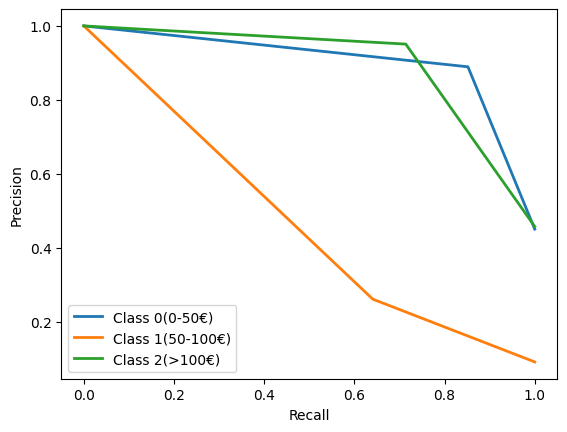

In [244]:
# precision recall curve
precision = dict()
recall = dict()
for i in range(n_classes):
    label = ''
    if i == 0:
        label = 'Class 0(0-50€)'
    elif i == 1:
        label = 'Class 1(50-100€)'
    else:
        label = 'Class 2(>100€)'

    precision[i], recall[i], _ = precision_recall_curve(y_true_binarize[:, i],
                                                        y_pred_binarize[:, i])
    plt.plot(recall[i], precision[i], lw=2, label=label)
    
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
# plt.title("Precision vs recall curve")
plt.show()


## Plot Satisfiability and Accuracy

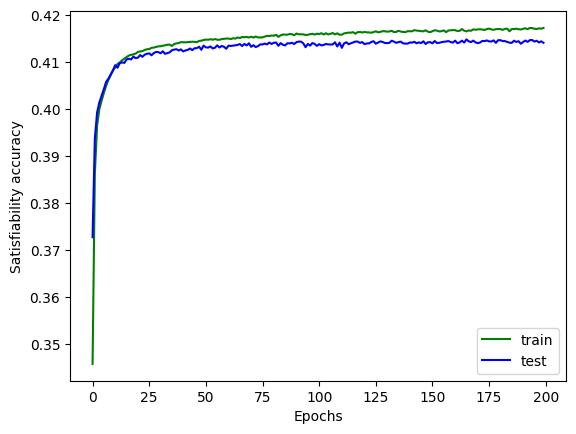

In [224]:
import pandas as pd
import matplotlib.pyplot as plt

# file = pd.read_csv('intellizenz_results_v1.csv')
# file = pd.read_csv('intellizenz_results_v2.csv')
# file = pd.read_csv('intellizenz_results_v4.csv')
# file = pd.read_csv('intellizenz_results_v5.csv')
file = pd.read_csv('intellizenz_results_v6.csv')


sat_train_acc = file['train_sat_kb']
sat_test_acc = file['test_sat_kb']

train_acc = file['train_accuracy']
test_acc = file['test_accuracy']

epochs = file['Epoch']

plt.plot(epochs, sat_train_acc, 'g', label='train')
plt.plot(epochs, sat_test_acc, 'b', label='test')
# plt.title('Training and testing set satisfiability performance')
plt.xlabel('Epochs')
plt.ylabel('Satisfiability accuracy')
plt.legend()
plt.show()

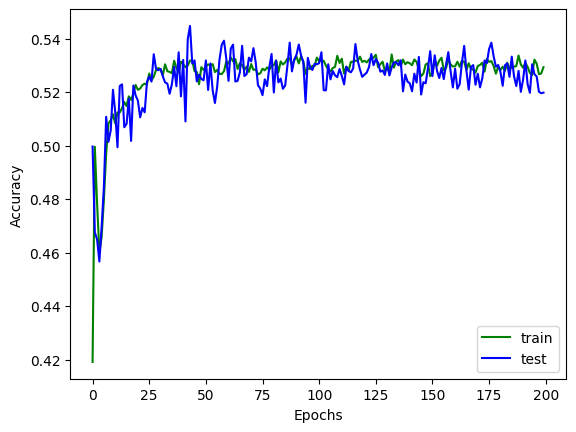

In [225]:
plt.plot(epochs, train_acc, 'g', label='train')
plt.plot(epochs, test_acc, 'b', label='test')
# plt.title('Training and testing classification performance')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()